#20190128
First we need to just generate these figures as stills for figures, potentially with a color scale:

1. We need to retain the conversion to radians..

In [1]:
#import what you need
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn
import os

import djp_graphing

In [2]:
os.listdir(os.getcwd())

['.git',
 '.ipynb_checkpoints',
 '3biorepsLinescantoAnalysis.ipynb',
 'AcMT_Quant.cpproj',
 'CNNexport_2channel.ijm',
 'CNNtoImageAnalysis.ipynb',
 'CNN_predictionsONLY.ipynb',
 'CNN_train&predict.ipynb',
 'djp_graphing.ipynb',
 'djp_graphing.py',
 'GenerateIDs&Coords.ipynb',
 'HCMVplaques.cpproj',
 'HCMVplaques_CK666.cpproj',
 'ID_NUC.cpproj',
 'LinescantoAnalysis.ipynb',
 'MOCK_Linescan_3channel.ijm',
 'MOCK_Linescan_4channel.ijm',
 'NuclearRotation_plot.ipynb',
 'RC_Quant.cpproj',
 'README.md',
 'TB_Linescan_3channel.ijm',
 'TB_Linescan_4channel.ijm',
 'TrainngValidationSetSorter.ipynb',
 '__pycache__']

In [3]:
#import tracking data saved from (need to convert to UTF-8 endcoding, WORKAROUND: just open and resave in excel)
trace_path = r'Results from WT_K40R_MOV in µm per sec.csv'
exp_ID = trace_path[13:-18]
#exp_ID = trace_path.split('\\')[-1][:-4]
print(exp_ID)
df_rotations = pd.read_csv(trace_path, encoding="utf8") ### YOU CAN SKIP THIS PROBLEM BY SETTING encoding="ansi", works a charm! ANSI#what is the encoding exported by imagej?
df_rotations

WT_K40R_MOV


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xb5 in position 28: invalid start byte

In [18]:
siRNA = "K40R"

#extract trace 1 and trace 2 into separate datframes (reset indexes to enable simplified merging, if you wish)
df_rotations_NUC = df_rotations[df_rotations["Track n°"] == 3].reset_index()
df_rotations_AC = df_rotations[df_rotations["Track n°"] == 4].reset_index()

#extract just the X,Y coords
df_NUC_coords = df_rotations_NUC[["X","Y"]]
df_AC_coords = df_rotations_AC[["X","Y"]]
df_ROTATE_coords = pd.DataFrame()
df_ROTATE_coords["X"] = df_AC_coords["X"] - df_NUC_coords["X"]
df_ROTATE_coords["Y"] = df_AC_coords["Y"] - df_NUC_coords["Y"]

df_ROTATE_coords.head()
frame_no = df_ROTATE_coords.shape[0]
print(f'{frame_no} frames tracked through stack')

71 frames tracked through stack


In [19]:
X_OFFSET = 0.1 # to control how far the scale is from the plot (axes coordinates)
LOWER_BOUND = 50


def add_scale(ax):
    # add extra axes for the scale
    rect = ax.get_position()
    rect = (rect.xmin-X_OFFSET, (rect.ymin+rect.height/2*0.75), # x, y
            rect.width, rect.height/2*1.2) # width, height
    #rect = (rect.xmin-X_OFFSET, rect.ymin-0.015+rect.height/4, # x, y
    #    rect.width, rect.height/1.4) # width, height
    scale_ax = ax.figure.add_axes(rect)
    
    # hide most elements of the new axes
    for loc in ['right', 'top', 'bottom']:
        scale_ax.spines[loc].set_visible(False)
    
    scale_ax.tick_params(bottom=False, labelbottom=False)
    scale_ax.patch.set_visible(False) # hide white background
    
    # adjust the scale
    scale_ax.spines['left'].set_bounds(LOWER_BOUND, 130) # djp set these manually
    scale_ax.set_yticks(ax.get_yticks())
    scale_ax.set_ylabel('h.p.i.', rotation='horizontal',size=16)
    scale_ax.yaxis.set_label_coords(-0.04,1.05)
    

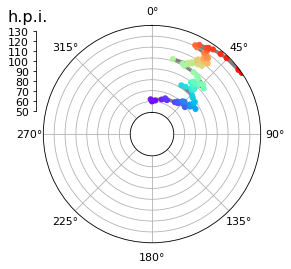

In [20]:
mpl.rcParams['font.size'] = 11

df = df_ROTATE_coords
#df['x'] = df_rotations[str(samplename + "x")]
#df['y']= df_rotations[str(samplename + "y")]

#conver this to radius and angle (theta)
#df['r'] = (df['X']*df['X'] + df['Y']*df['Y']).apply(np.sqrt)
df['theta'] = np.arctan2(df['Y'],df['X'])
theta_first = df['theta'][0]
#print(theta_first)
df['theta_change'] = df['theta'] - theta_first

start_time = 60

hpi = np.linspace(start_time,(start_time+frame_no), num=frame_no)
#print(hpi)

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, projection='polar')

ax.plot(df['theta_change'],hpi, linewidth=3.5,alpha=0.5,color='k',zorder=1)
ax.scatter(df['theta_change'],hpi, c=hpi, cmap='rainbow', marker='.',s=100,zorder=2)

ax.set_rorigin(30)
ax.set_rlim(LOWER_BOUND,130)
#ax.set_rlabel_position(270)
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.set_yticklabels([])
#ax.set_yticks(np.linspace(40,130,(130-50)/10+1,endpoint=True))
#ax.set_xticks(np.pi/180. * np.linspace(0,  360, 12, endpoint=False))
X_OFFSET = 0.025
add_scale(ax) #defined above
plt.savefig(f'{exp_ID}_{siRNA}_ROTATIONTRACE_v2.png', dpi=1200, bbox_inches = "tight")
plt.show()

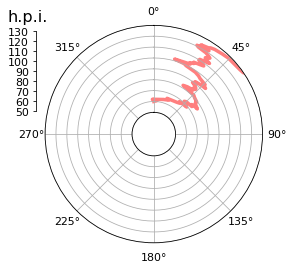

In [21]:
from matplotlib.animation import FFMpegWriter
import os
os.system('ffmpeg')

writer = FFMpegWriter(fps=15, codec='mjpeg')

df = df_ROTATE_coords
#df['x'] = rotate[str(sample + "x")]
#df['y']= rotate[str(sample + "y")]

#r = (df['X']*df['X'] + df['Y']*df['Y']).apply(np.sqrt)
t_raw = np.arctan2(df['Y'],df['X'])
t = t_raw - t_raw[0]
hpi = np.linspace(start_time,(start_time+frame_no), num=frame_no)

fig = plt.figure(figsize=(5,4))
ax = fig.add_subplot(111, projection='polar')

ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
#ax.set_rorigin(40)
#ax.set_rlim(60,140)
#ax.set_yticklabels([])
#ax.set_yticks(np.linspace(60,140,5,endpoint=True))

line,  = ax.plot(t,hpi, linewidth=3.5,alpha=0.5,color='red',zorder=1)

def update(num, hpi, t, line):
    line.set_xdata(t[:(num+1)])
    line.set_ydata(hpi[:(num+1)])
    return line,
ax.set_rorigin(30)
ax.set_rlim(LOWER_BOUND,130)
ax.set_yticklabels([])
add_scale(ax)
#ax.set_rticks(np.linspace(60,240,10,endpoint=True))

ani = animation.FuncAnimation(fig, update, len(hpi), fargs=[hpi, t, line], interval=25, blit=True)
name_mp4 = str(f'{exp_ID}_{siRNA}_ROTATE_ANIMATE.avi')
ani.save(name_mp4, writer=writer,dpi=150)
plt.show()

## OR USE THIS TO FILL UP A LIST OF SAMPLENAMES IMPORTED FROM THE CSV

samplelist = ['099_20181013']
for sample in samplelist:
    df = pd.DataFrame()
    df['x'] = df_rotations[str(sample + "x")]
    df['y']= df_rotations[str(sample + "y")]

    #conver this to radius and angle (theta)
    df['r'] = (df['x']*df['x'] + df['y']*df['y']).apply(np.sqrt)
    df['theta'] = np.arctan2(df['y'],df['x'])
    theta_first = df['theta'][0]
    #print(theta_first)
    df['theta_change'] = df['theta'] - theta_first

    hpi = np.linspace(65,145, num=73)
    #print(hpi)

    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111, projection='polar')

    ax.plot(df['theta_change'],hpi, linewidth=3.5,alpha=0.3,color='k',zorder=1)
    ax.scatter(df['theta_change'],hpi, c=hpi, cmap='rainbow', marker='.',s=100,zorder=2)

    ax.set_rorigin(40)
    ax.set_rlim(60,140)
    #ax.set_rlabel_position(270)
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    ax.set_yticklabels([])
    ax.set_yticks(np.linspace(60,140,5,endpoint=True))
    #ax.set_xticks(np.pi/180. * np.linspace(0,  360, 12, endpoint=False))
    add_scale(ax) #defined above
    plt.savefig(str(sample) +".png", dpi=600)
    plt.show()

In [ ]:
import nupy as np
import matplotlib
matplotlibe.use("Agg")
import matplotlib.pyplot as plt
import matplotlib.animation as animation

def update_line(num, data, line):
    line.set_data(datat[..., :num])
    return line,

np.random.seed(19680801)

Writer = animation.writers['ffmpeg']
writer = Writer(fps,metadata=dict(artist='Me'), bitrate=1800)

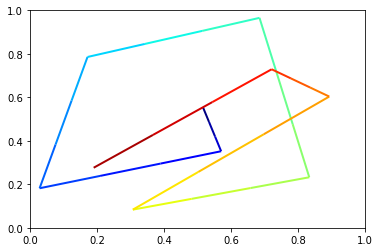

In [34]:
###THIS IS AN EXAMPLE TO GENERATE A COLOR LINE

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.collections as mcoll
import matplotlib.path as mpath

def colorline(
    x, y, z=None, cmap=plt.get_cmap('copper'), norm=plt.Normalize(0.0, 1.0),
        linewidth=3, alpha=1.0):
    """
    http://nbviewer.ipython.org/github/dpsanders/matplotlib-examples/blob/master/colorline.ipynb
    http://matplotlib.org/examples/pylab_examples/multicolored_line.html
    Plot a colored line with coordinates x and y
    Optionally specify colors in the array z
    Optionally specify a colormap, a norm function and a line width
    """

    # Default colors equally spaced on [0,1]:
    if z is None:
        z = np.linspace(0.0, 1.0, len(x))

    # Special case if a single number:
    if not hasattr(z, "__iter__"):  # to check for numerical input -- this is a hack
        z = np.array([z])

    z = np.asarray(z)

    segments = make_segments(x, y)
    lc = mcoll.LineCollection(segments, array=z, cmap=cmap, norm=norm,
                              linewidth=linewidth, alpha=alpha)

    ax = plt.gca()
    ax.add_collection(lc)

    return lc


def make_segments(x, y):
    """
    Create list of line segments from x and y coordinates, in the correct format
    for LineCollection: an array of the form numlines x (points per line) x 2 (x
    and y) array
    """

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    return segments

N = 10
np.random.seed(101)
x = np.random.rand(N)
y = np.random.rand(N)
fig, ax = plt.subplots()

path = mpath.Path(np.column_stack([x, y]))
verts = path.interpolated(steps=3).vertices
x, y = verts[:, 0], verts[:, 1]
z = np.linspace(0, 1, len(x))
colorline(x, y, z, cmap=plt.get_cmap('jet'), linewidth=2)

plt.show()

In [ ]:
print(rotate.columns)
xlist = ['c34x', 'c1x',  'c3x',  'c8x', 'leaa44x', 'leaa5x',  'leaa26x',  'leaa2x', 'n10ax',  'n29x',  'n6x', 'n10bx', 'n20x',  'nc6x',  'nc8x',  'nc9x', 'nc14x']
ylist = ['c34y', 'c1y', 'c3y', 'c8y', 'leaa44y', 'leaa5y', 'leaa26y', 'leaa2y', 'n10ay', 'n29y', 'n6y', 'n10by', 'n20y', 'nc6y', 'nc8y', 'nc9y', 'nc14y']

In [7]:
from matplotlib.animation import FFMpegWriter
writer = FFMpegWriter(fps=15, bitrate=1800)

samplelist = ['c34', 'c1', 'c3', 'c8', 'leaa44', 'leaa5', 'leaa26', 'leaa2', 'n10a', 'n29', 'n6', 'n10b', 'n20', 'nc6', 'nc8', 'nc9', 'nc14']

for sample in samplelist:
    df = pd.DataFrame()
    df['x'] = rotate[str(sample + "x")]
    df['y']= rotate[str(sample + "y")]
    r = (df['x']*df['x'] + df['y']*df['y']).apply(np.sqrt)
    t = np.arctan2(df['y'],df['x'])
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111, projection='polar')
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)  
    line,  = ax.plot(t,r)
    def update(num, r, t, line):
        line.set_xdata(t[:num])
        line.set_ydata(r[:num])
        return line,
    ani = animation.FuncAnimation(fig, update, len(r), fargs=[r, t, line], interval=25, blit=True)
    name_mp4 = str(sample +".mp4")
    ani.save(name_mp4, writer=writer)
    plt.show()

NameError: name 'rotate' is not defined

In [8]:
import pandas as pd
import numpy as np

test = np.linspace(1,10,10)
print(test)
pd.DataFrame(test,test)

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


,0
1.0,1.0
2.0,2.0
3.0,3.0
4.0,4.0
5.0,5.0
6.0,6.0
7.0,7.0
8.0,8.0
9.0,9.0
10.0,10.0
